In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


output_dir_path = '../boosting/outputs/CatBoost/20230523_154321/'

### (Option) 안넣어주셔도 됩니다. 
train_csv_path = '../boosting/outputs/CatBoost/20230523_154321/fold1/train_data.csv'
### (Option) confusion matrix에서 각 영역에 해당하는 Userid 뽑아내려면 필요합니다.
test_csv_path =  '../boosting/outputs/CatBoost/20230523_154321/fold1/test_data.csv'

### (Must) 정답 csv 파일과 예측 csv 파일 경로를 넣어주세요
answer_csv_path = '../boosting/outputs/CatBoost/20230523_154321/fold1/answer.csv'
predict_csv_path = '../boosting/outputs/CatBoost/20230523_154321/fold1/fold1_20230523_154321_0.83355_catboost_predict.csv'

df_dict = {}

if train_csv_path:
    df_dict['train'] = pd.read_csv(train_csv_path)
if test_csv_path:
    df_dict['test'] = pd.read_csv(test_csv_path)

df_dict['answer'] = pd.read_csv(answer_csv_path)
df_dict['predict'] = pd.read_csv(predict_csv_path)

if len(df_dict['answer']) != len(df_dict['predict']):
    raise ValueError('answer와 predict의 row가 맞지 않음')


In [24]:
df_dict['analyze'] = df_dict['predict'].copy()

df_dict['analyze']['answerCode'] = df_dict['answer']['answerCode']
df_dict['analyze']['yhat'] = df_dict['analyze']['prediction'].map(lambda x : 1 if x >= 0.5 else 0)

if 'test' in df_dict.keys():
    df_dict['analyze'].id = df_dict['test'].userID.unique()
    df_dict['TP_user_id'] = df_dict['analyze'].loc[(df_dict['analyze']['answerCode'] == 1) & (df_dict['analyze']['yhat'] == 1)]['id'].values
    df_dict['TN_user_id'] = df_dict['analyze'].loc[(df_dict['analyze']['answerCode'] == 0) & (df_dict['analyze']['yhat'] == 0)]['id'].values
    df_dict['FP_user_id'] = df_dict['analyze'].loc[(df_dict['analyze']['answerCode'] == 0) & (df_dict['analyze']['yhat'] == 1)]['id'].values
    df_dict['FN_user_id'] = df_dict['analyze'].loc[(df_dict['analyze']['answerCode'] == 1) & (df_dict['analyze']['yhat'] == 0)]['id'].values


In [25]:
df_dict['CM'] = confusion_matrix(
    y_true = df_dict['analyze']['answerCode'], y_pred = df_dict['analyze']['yhat']
) # tn, fp, fn, tp

df_dict['CM'] = np.flip(np.flip(df_dict['CM'], 0), 1) # tp fn
                                                      # fp tn
                                                      
df_dict['precision'] = precision_score(df_dict['analyze']['answerCode'], df_dict['analyze']['yhat'])
df_dict['recall'] = recall_score(df_dict['analyze']['answerCode'], df_dict['analyze']['yhat'])
df_dict['f1'] = f1_score(df_dict['analyze']['answerCode'], df_dict['analyze']['yhat'])
df_dict['auroc'] = roc_auc_score(df_dict['analyze']['answerCode'], df_dict['analyze']['prediction'])

In [26]:
df_dict['CM']

array([[432, 153],
       [254, 353]])

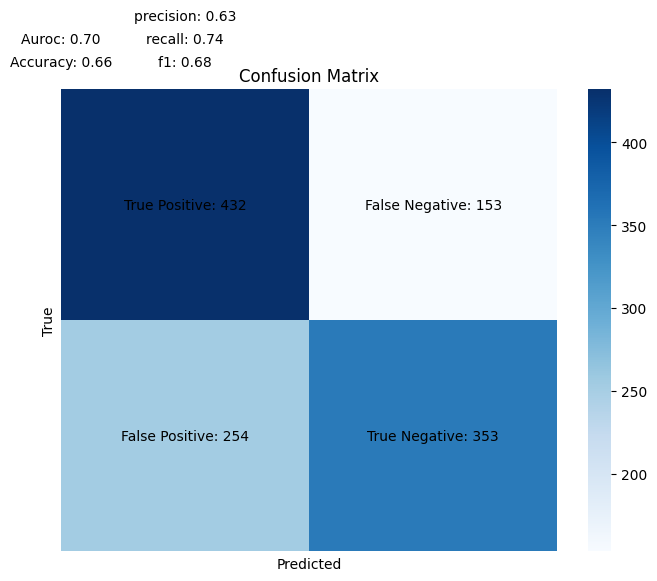

In [27]:
cm = df_dict['CM']
auroc = df_dict['auroc']
precision = df_dict['precision']
recall = df_dict['recall']
f1 = df_dict['f1']

plt.figure(figsize=(8, 6))
sns.heatmap(df_dict['CM'], annot=False, fmt='d', cmap='Blues', xticklabels='', yticklabels='')
total_samples = np.sum(cm)
accuracy = np.trace(cm) / total_samples
misclass = 1 - accuracy

plt.text(0.0, -0.1, f'Accuracy: {accuracy:.2f}', ha='center')
plt.text(0.0, -0.2, f'Auroc: {auroc:.2f}', ha='center')
plt.text(0.5, -0.1, f'f1: {f1:.2f}', ha='center')
plt.text(0.5, -0.2, f'recall: {recall:.2f}', ha='center')
plt.text(0.5, -0.3, f'precision: {precision:.2f}', ha='center')

plt.text(0.5, 0.5, f'True Positive: {cm[0,0]}', ha='center', va='center', color='black')
plt.text(1.5, 0.5, f'False Negative: {cm[0,1]}', ha='center', va='center', color='black')
plt.text(0.5, 1.5, f'False Positive: {cm[1,0]}', ha='center', va='center', color='black')
plt.text(1.5, 1.5, f'True Negative: {cm[1,1]}', ha='center', va='center', color='black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()